C:\Users\86158\AppData\Local\Temp\ipykernel_2016\4183372187.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


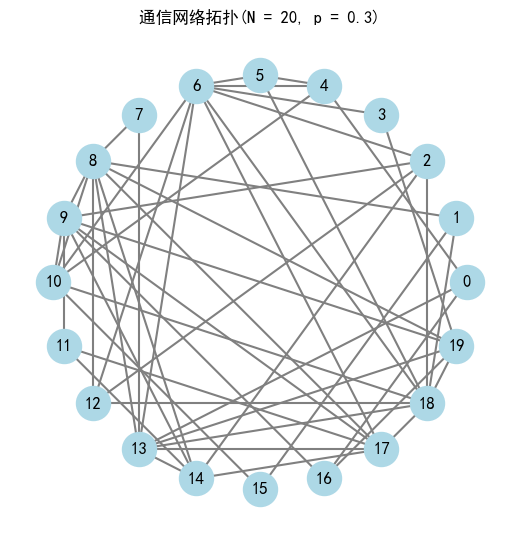

迭代 10000/100000, 最大L1误差 = 7.7545
迭代 20000/100000, 最大L1误差 = 6.0551
迭代 30000/100000, 最大L1误差 = 5.1895
迭代 40000/100000, 最大L1误差 = 4.4761
迭代 50000/100000, 最大L1误差 = 4.0130
迭代 60000/100000, 最大L1误差 = 3.8100
迭代 70000/100000, 最大L1误差 = 3.7154
迭代 80000/100000, 最大L1误差 = 3.6603
迭代 90000/100000, 最大L1误差 = 3.5990
迭代 100000/100000, 最大L1误差 = 3.5648


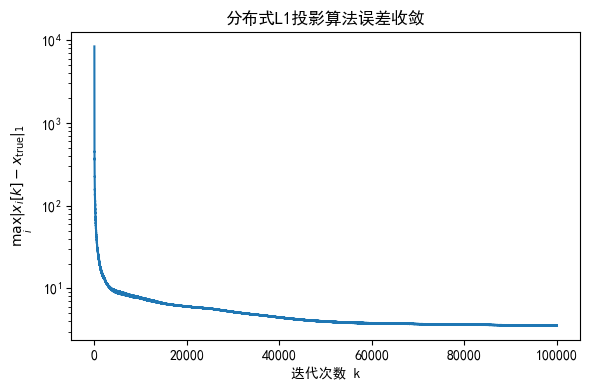

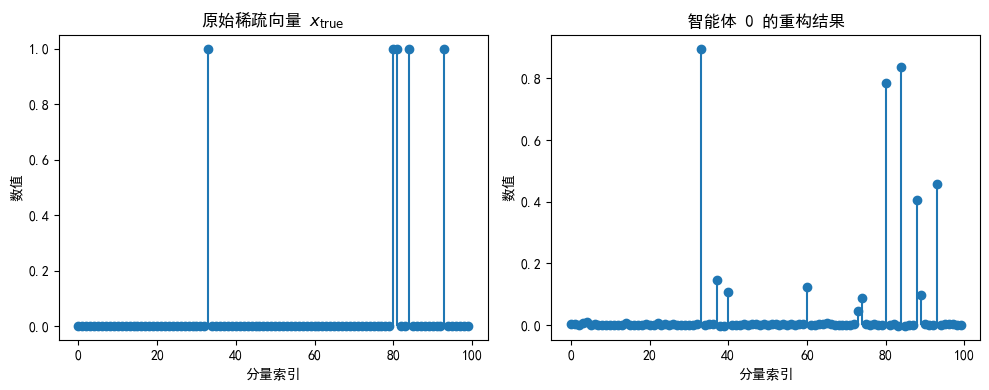

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# 配置参数 - 对应例6.8的设置
np.random.seed(1)

n_dimension = 100    # 待检测人数/向量维度  
m_tests = 20         # 群体检测次数
N_agents = m_tests   # 智能体数量 N = m = 20
edge_prob = 0.3      # 网络连接概率

# 算法迭代参数
MAX_ITERATIONS = 100000

# 步长函数 α_k = 100/(1+k) - 公式(6.115)
def compute_step(k):
    return 100.0 / (1.0 + k)

def l1_subgradient(x_vector):
    """
    计算L1范数的次梯度
    当x_i>0时为1，x_i<0时为-1，x_i=0时为0
    """
    gradient = np.sign(x_vector)
    gradient[x_vector == 0] = 0.0
    return gradient


# ========== 生成原始稀疏向量 x_true ==========
x_true = np.zeros(n_dimension)
nonzero_indices = np.random.choice(n_dimension, size=5, replace=False)
x_true[nonzero_indices] = 1.0

A_matrix = (np.random.rand(m_tests, n_dimension) < 0.25).astype(float)

# 确保每行至少有一个非零元素
for row_idx in range(m_tests):
    if A_matrix[row_idx].sum() == 0:
        A_matrix[row_idx, np.random.randint(0, n_dimension)] = 1.0

# 生成观测向量
y_observed = A_matrix @ x_true

# 分配数据到各个智能体
agent_A = [A_matrix[i].copy() for i in range(N_agents)]
agent_y = [y_observed[i].copy() for i in range(N_agents)]


# ========== 构建通信网络和权重矩阵 ==========
network_G = nx.erdos_renyi_graph(N_agents, edge_prob, seed=0)

# 可视化通信网络
fig = plt.figure(figsize=(5, 5))
layout = nx.circular_layout(network_G)
nx.draw(
    network_G,
    layout,
    with_labels=True,
    node_color="lightblue",
    node_size=600,
    edge_color="gray",
    width=1.5,
)
plt.title("通信网络拓扑(N = 20, p = 0.3)")
plt.tight_layout()
plt.show()

# 构建权重矩阵P
weight_matrix = np.zeros((N_agents, N_agents))
for node in range(N_agents):
    neighbors_list = list(network_G.neighbors(node))
    neighbors_list.append(node)  # 包含自身
    degree_count = len(neighbors_list)
    for neighbor in neighbors_list:
        weight_matrix[node, neighbor] = 1.0 / degree_count


# ========== L1范数次梯度计算 ==========


# 初始化所有智能体的估计
X_estimates = np.ones((N_agents, n_dimension))
error_history = []  # 记录误差变化

# ========== 主算法循环 ==========
for iteration in range(MAX_ITERATIONS):
    current_step = compute_step(iteration)

    # 共识步骤和次梯度更新
    consensus_V = weight_matrix @ X_estimates
    consensus_V = consensus_V - current_step * l1_subgradient(X_estimates)

    # 投影到局部约束集合
    X_updated = np.zeros_like(X_estimates)
    for agent_id in range(N_agents):
        a_vector = agent_A[agent_id]
        y_value = agent_y[agent_id]
        v_vector = consensus_V[agent_id]

        denominator = float(a_vector @ a_vector)
        if denominator < 1e-12:
            X_updated[agent_id] = v_vector
        else:
            projection_residual = y_value - a_vector @ v_vector
            X_updated[agent_id] = v_vector + (projection_residual / denominator) * a_vector

    X_estimates = X_updated

    # 计算并记录误差
    agent_errors = np.linalg.norm(X_estimates - x_true[None, :], ord=1, axis=1)
    error_history.append(agent_errors.max())

    if (iteration + 1) % 10000 == 0:
        print(f"迭代 {iteration+1}/{MAX_ITERATIONS}, 最大L1误差 = {error_history[-1]:.4f}")


# ========== 绘制误差收敛曲线 ==========
plt.figure(figsize=(6, 4))
plt.plot(range(MAX_ITERATIONS), error_history)
plt.yscale("log")
plt.xlabel("迭代次数 k")
plt.ylabel(r"$\max_i \|x_i[k] - x_{\mathrm{true}}\|_1$")
plt.title("分布式L1投影算法误差收敛")
plt.tight_layout()
plt.show()


# ========== 比较原始向量和重构结果 ==========
selected_agent = 0
x_reconstructed = X_estimates[selected_agent]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.stem(range(n_dimension), x_true, basefmt=" ")
ax1.set_title(r"原始稀疏向量 $x_{\mathrm{true}}$")
ax1.set_xlabel("分量索引")
ax1.set_ylabel("数值")

ax2.stem(range(n_dimension), x_reconstructed, basefmt=" ")
ax2.set_title(f"智能体 {selected_agent} 的重构结果")
ax2.set_xlabel("分量索引")
ax2.set_ylabel("数值")

plt.tight_layout()
plt.show()